Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Digit Recognition with Convolutional Neural Networks

## Install Tensorflow 2.2

In [ ]:
"""
LeNet Implementation in TF2
https://heartbeat.fritz.ai/fully-training-a-core-ml-convolutional-neural-network-on-device-1483750e846
"""

!pip install tensorflow==2.2

     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 460kB 53.6MB/s 
     |████████████████████████████████| 3.0MB 56.1MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


## Import the required libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

print(tf.__version__)

2.4.1


## Import MNIST dataset from Keras API

In [ ]:
# Loading the mnist image dataset available in keras
mnist              = keras.datasets.mnist

# Splitting the data in train and test images 
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# The below lines can be used to increase the training data by repeating the data
duplication_factor = 1
train_images       = np.repeat(train_images,axis=0,repeats=duplication_factor)
train_labels       = np.repeat(train_labels,axis=0,repeats=duplication_factor)

# Normalize the input image so that each pixel value is between 0 to 1.
train_images       = train_images / 255.0
test_images        = test_images / 255.0

# Add a color dimension to the images in "train" and "validate" dataset to
#leverage Keras's data augmentation utilities later.
train_images       = np.expand_dims(train_images, axis=3)
test_images        = np.expand_dims(test_images, axis=3)

## Plot few of the images and display their corresponding labels

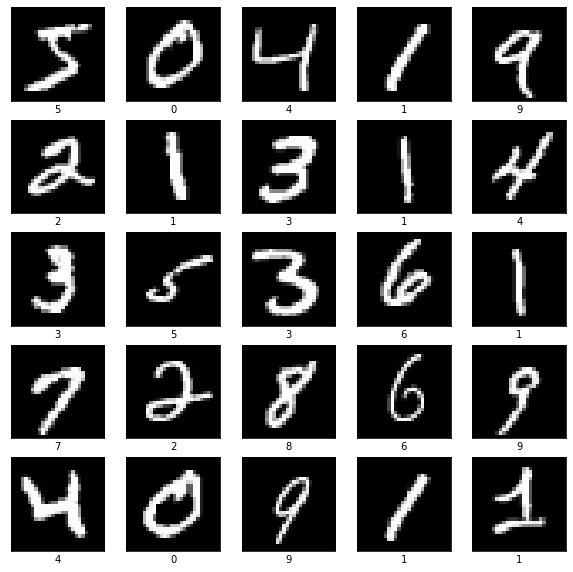

In [ ]:
# Show the first 25 images in the training dataset.
plt.figure(figsize = (10, 10))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.squeeze(train_images[i], axis=2), cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

## Define the CNN model with the required layers

In [ ]:
# Utility to define a sample CNN model
def create_model():
  model = keras.Sequential([
    keras.layers.InputLayer(input_shape = (28, 28, 1)),                             # The input layer
    keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation=tf.nn.relu), # 1st convolutional layer with activation relu
    keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation=tf.nn.relu), # 2nd convolutional layer with activation relu
    keras.layers.MaxPooling2D(pool_size = (2, 2)),                                  # Adding a max-pooling layer
    keras.layers.Dropout(0.25),                                                     # Dropout layer with rate = 0.25
    keras.layers.Flatten(),                                                         # Flattening the layer to be fed into final layer
    keras.layers.Dense(10, activation=tf.nn.softmax)                                # Final output layer to get the probablities of the the image
  ])

  # Choosing the optimizer, loss and accuracy functions
  model.compile(optimizer = 'adam',
                loss      = 'sparse_categorical_crossentropy',
                metrics   = ['accuracy'])
  return model

#Utility to define the LeNet CNN model for digit recognition
def create_model_lenet():
  model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),                                                                                         # The Input layer
    keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = tf.nn.relu, kernel_initializer = tf.keras.initializers.he_uniform()),# 1st convolutional layer with activation relu
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.Conv2D(filters = 32, kernel_size = (2, 2), activation = tf.nn.relu, kernel_initializer = tf.keras.initializers.he_uniform()),# 2nd convolutional layer with activation relu
    keras.layers.MaxPooling2D(pool_size = (2, 2)),                                                                                            # Adding a maxpooling layer
    keras.layers.Flatten(),                                                                                                                   # flattening the layer to make it 1D
    keras.layers.Dropout(0.25),                                                                                                               # dropout layer with rate=0.25
    keras.layers.Flatten(),                                                                                                                   # flattening the layer to make it 1D
    keras.layers.Dense(500, activation = tf.nn.relu, kernel_initializer = tf.keras.initializers.he_uniform()),                                # 500 layer fully connected layer
    keras.layers.Dense(10, activation  = tf.nn.softmax)                                                                                       # final output layer to get each digit probabilities
  ])

  # Choosing the optimizer , loss and accuracy functions
  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  print(model.summary())

  return model

# Train the LeNet CNN model

In [ ]:
base_model = create_model_lenet()

# Fitting the model and training with 5 epochs
base_model.fit(train_images, train_labels, epochs = 5, batch_size = 32, validation_data = (test_images, test_labels))                        # the batch size also can be changed

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        4128      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1152)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)             

# Distribution of images within the 28X28 square

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71bb9aecd0>,
      dtype=object)

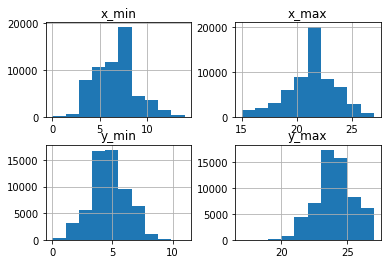

In [ ]:
# An utility function that returns where the digit is in the image.
def digit_area(mnist_image):
  # Remove the color axes
  mnist_image = np.squeeze(mnist_image, axis = 2)

  # Extract the list of columns that contain at least 1 pixel from the digit
  x_nonzero = np.nonzero(np.amax(mnist_image, 0))
  x_min     = np.min(x_nonzero)
  x_max     = np.max(x_nonzero)
  
  # Extract the list of rows that contain at least 1 pixel from the digit
  y_nonzero = np.nonzero(np.amax(mnist_image, 1))
  y_min     = np.min(y_nonzero)
  y_max     = np.max(y_nonzero)

  # Return call
  return [x_min, x_max, y_min, y_max]

# Calculate the area containing the digit across MNIST dataset
digit_area_rows  = []
for image       in train_images:
  digit_area_row = digit_area(image)
  digit_area_rows.append(digit_area_row)

digit_area_df    = pd.DataFrame(digit_area_rows, columns = ['x_min', 'x_max', 'y_min', 'y_max'])
digit_area_df.hist()

# Augment the images by applying certain transformations

In [ ]:
# Define data augmentation - applying transformations on the data like rotation, shifting, etc.
datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range = 30, width_shift_range = 0.25, height_shift_range = 0.25, shear_range = 0.25, zoom_range = 0.2)

# Generate augmented data from MNIST dataset
train_generator = datagen.flow(train_images, train_labels)
test_generator  = datagen.flow(test_images, test_labels)

# Plot few examples from the augmented dataset

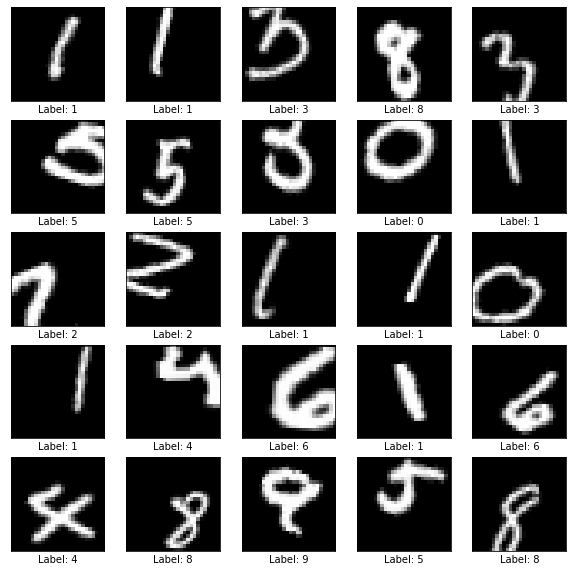

In [ ]:
#plotting augmented images
augmented_images, augmented_labels = next(train_generator)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(augmented_images[i], axis=2), cmap=plt.cm.gray)
    plt.xlabel('Label: %d' % augmented_labels[i])
plt.show()

# Evaluate the performance of the model on the augmented dataset

In [ ]:
base_model.evaluate(test_generator, batch_size = 32)                                    # the batch size also can be changed

313/313 [==============================] - 3s 9ms/step - loss: 4.3535 - accuracy: 0.3380


[4.353522300720215, 0.33799999952316284]

# Fit an improved model using the augmented dataset

In [ ]:
improved_model = create_model_lenet()
improved_model.fit(train_generator, epochs = 5, validation_data = test_generator, batch_size = 32)                                 # the batch size also can be changed

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 32)        4128      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1152)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)             

# Predict on the augmented test data

In [ ]:
improved_model.evaluate(test_generator, batch_size = 32)                                                                # the batch size also can be changed

313/313 [==============================] - 3s 9ms/step - loss: 0.1217 - accuracy: 0.9614


[0.12165027856826782, 0.9613999724388123]

# Predict using the improved model on the original test data

In [ ]:
improved_model.evaluate(test_images, test_labels, batch_size = 32)                                                      # the batch size also can be changed

313/313 [==============================] - 1s 2ms/step - loss: 0.0561 - accuracy: 0.9811


[0.056078772991895676, 0.9811000227928162]

# Convert to TensorFlow Lite

In [ ]:
# Convert Keras model to TF Lite format and quantize.
converter = tf.lite.TFLiteConverter.from_keras_model(improved_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the quantized model to file to the Downloads directory
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('mnist.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

APK file for Installing MNIST android app


In [ ]:
https://github.com/vsskanand/Memory-Profiling-On-Edge-Devices


# Monitoring memory and system level details

## Get System Details (in Python)

In [ ]:
import numpy as np
import psutil
import platform
import sys
import tensorflow as tf
from tensorflow.python.client import device_lib

gb_num = 1024 * 1024 * 1024


print("="*18, "Memory Information", "="*18)

print(f"CPU Percent: {psutil.cpu_percent()}")
print(f"Virtual Memory: {psutil.virtual_memory()._asdict()}")
print(f"RAM Used (%): {np.round(psutil.virtual_memory().percent, 2)}")
print(f"RAM Available (%): {np.round(100 * (psutil.virtual_memory().available/ psutil.virtual_memory().total), 2)}")


print(f"RAM Used (Gb): {np.round(psutil.virtual_memory().used / gb_num, 2)} Gb")
print(f"RAM Active (Gb): {np.round(psutil.virtual_memory().active / gb_num, 2)} Gb")
print(f"RAM InActive (Gb): {np.round(psutil.virtual_memory().inactive / gb_num, 2)} Gb")
print(f"RAM Available (Gb): {np.round(psutil.virtual_memory().available / gb_num, 2)} Gb")
print(f"RAM Total (Gb): {np.round(psutil.virtual_memory().total / gb_num, 2)} Gb")

================== Memory Information ==================
CPU Percent: 25.0
Virtual Memory: OrderedDict([('total', 13653557248), ('available', 12657426432), ('percent', 7.3), ('used', 710598656), ('free', 10815664128), ('active', 1091833856), ('inactive', 1415430144), ('buffers', 86245376), ('cached', 2041049088), ('shared', 1032192), ('slab', 178286592)])
RAM Used (%): 7.3
RAM Available (%): 92.7
RAM Used (Gb): 0.66 Gb
RAM Active (Gb): 1.02 Gb
RAM InActive (Gb): 1.32 Gb
RAM Available (Gb): 11.79 Gb
RAM Total (Gb): 12.72 Gb


In [ ]:


print("="*18, "System Information", "="*18)
uname = platform.uname()

print(f">>> Sytem \t\t: {uname.system}")
print(f">>> Node Name \t\t: {uname.node}")
print(f">>> Release \t\t: {uname.release}")
print(f">>> Version \t\t: {uname.version}")
print(f">>> Machine \t\t: {uname.machine}")
print(f">>> Processor \t\t: {uname.processor}")

device_name = tf.test.gpu_device_name()
available_local_devices = device_lib.list_local_devices()

# print(available_local_devices)

print("="*56)

for device in available_local_devices:
  if device.device_type == "TPU":
    print("TPU")
  elif device.device_type == "GPU":
    print(">>> Device Information")
    print(f"\t] Device Name : {device.name}")
    print(f"\t] Device Type : {device.device_type}")
    print(f"\t] Memory      : {round(device.memory_limit / gb_num, 2)} Gb")
    print(f"\t] Description : {device.physical_device_desc}")
    print(f"\t] Incarnation : {device.incarnation}")
  else:
    print("Device: CPU")
    

print("="*56)
print(sys.version)


================== System Information ==================
>>> Sytem 		: Linux
>>> Node Name 		: 9a65ec208cc8
>>> Release 		: 4.19.112+
>>> Version 		: #1 SMP Thu Jul 23 08:00:38 PDT 2020
>>> Machine 		: x86_64
>>> Processor 		: x86_64
Device: CPU
>>> Device Information
	] Device Name : /device:GPU:0
	] Device Type : GPU
	] Memory      : 13.67 Gb
	] Description : device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
	] Incarnation : 4612002984542997251
3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]


In [ ]:
try:
  """
  Google TPU https://cloud.google.com/tpu
  Tensorflow TPU https://www.tensorflow.org/guide/tpu
  """

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  available_tpu_devices = tf.config.list_logical_devices('TPU')

  for device in available_tpu_devices:
    print(device)
  
except:
  print("Change runtime type option to TPU")

Change runtime type option to TPU


In [ ]:
  print("="*18, "Disk Information", "="*18)

  print("Logical/Total Core Count: ", psutil.cpu_count(logical=True) )
  print("Physical Core Count: ", psutil.cpu_count(logical=False))
  
  partitions = psutil.disk_partitions() # get disk partitions

  print(partitions)

  for x in partitions:

    disk = psutil.disk_usage(x.mountpoint)

    print("] Drive: ", x.device)
    print("] Drive: ", x.device)
    print("\t] File system type: ", x.fstype)

    print("\t\t] Total Size: ", disk.total / gb_num)
    print("\t\t] Used:       ", disk.used/gb_num)
    print("\t\t] Free:       ", disk.free/gb_num)
    print("\t\t] Percentage: ", disk.percent, "%\n")

  freq=psutil.cpu_freq() # Get CPU frequencies
  
  if freq:
    print("Maximum Frequency:" ,freq.max, "Mhz")
    print("Minimum Frequency:", freq.min,"Mhz")
    print("Current Frequency: ",freq.current ,"Mhz")
  else:
    print("Unable to ger CPU Frequencies..!")

  # Get CPU usage.
  for x, percentage_usage in enumerate(psutil.cpu_percent(percpu=True)):
      print("Core ",x, ":",percentage_usage,"%")

  print("Total CPU Usage:", psutil.cpu_percent(),"%\n")

================== Disk Information ==================
Logical/Total Core Count:  2
Physical Core Count:  1
[sdiskpart(device='/dev/sda1', mountpoint='/usr/lib64-nvidia', fstype='ext4', opts='rw,nosuid,nodev,relatime,commit=30'), sdiskpart(device='/dev/sda1', mountpoint='/opt/bin', fstype='ext4', opts='rw,nosuid,nodev,relatime,commit=30'), sdiskpart(device='/dev/sda1', mountpoint='/etc/resolv.conf', fstype='ext4', opts='rw,nosuid,nodev,relatime,commit=30'), sdiskpart(device='/dev/sda1', mountpoint='/etc/hostname', fstype='ext4', opts='rw,nosuid,nodev,relatime,commit=30'), sdiskpart(device='/dev/sda1', mountpoint='/etc/hosts', fstype='ext4', opts='rw,nosuid,nodev,relatime,commit=30')]
] Drive:  /dev/sda1
] Drive:  /dev/sda1
	] File system type:  ext4
		] Total Size:  74.60099792480469
		] Used:        39.8656005859375
		] Free:        34.71977233886719
		] Percentage:  53.4 %

] Drive:  /dev/sda1
] Drive:  /dev/sda1
	] File system type:  ext4
		] Total Size:  74.60099792480469
		] Used: